In [1]:
%matplotlib inline
import numpy as np
from numpy.fft import fft2, ifft2
import cv2
from matplotlib import cm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def gaussian(u, v, sigma):
    return np.exp(-(np.square(u) + np.square(v))/(2*sigma**2))

# Calculate and plot the gaussian filter
def gaussian_filter(r, c, cut_freq, lowPass):
    center_x = int(r/2)
    center_y = int(c/2)
    
    fig = plt.figure(figsize=(8,6))
    ax = fig.add_subplot(111, projection='3d')
    
    X = np.arange(r)
    Y = np.arange(c)
    Y, X = np.meshgrid(Y, X)
    
    if lowPass:
        ax.set_title('Low Pass Filter')
        Z = gaussian(X-center_x, Y-center_y, cut_freq)
    else:
        ax.set_title('High Pass Filter')
        Z = 1 - gaussian(X-center_x, Y-center_y, cut_freq)
    
    surface = ax.plot_surface(X, Y, Z, cmap=plt.get_cmap('rainbow'))
    plt.show()
    return Z

# Shift the image in Spatial domain
def shiftImg(img, r, c):
    for r_ in range(r):
        for c_ in range(c):
            if (r_+c_)%2 != 0:
                img[r_, c_] = -img[r_, c_]
    return img

# Filter the DFT image and inver it to spatial domain
def filterDFT(img, r, c, filter):
    imgDFT = fft2(shiftImg(img, r, c))    
    result = np.real(ifft2(np.multiply(imgDFT, filter)))
    result = shiftImg(result, r, c)
    return result

# Plot BGR channel of the image
def plot_BGR(img, title):
    fig, axs = plt.subplots(1, 3, figsize=(9,3), sharey=True)
    fig.suptitle(title)
    
    axs[0].axis('off')
    axs[0].imshow(img[0])
    axs[0].set_title('Blue')
    
    axs[1].axis('off')
    axs[1].imshow(img[1])
    axs[1].set_title('Green')
    
    axs[2].axis('off')
    axs[2].imshow(img[2])
    axs[2].set_title('Red')
    plt.show()


def hybrid_image(highFreqImg, lowFreqImg, cutFreqHigh, cutFreqLow):
    # Calculate highpass filter
    r, c = highFreqImg[0].shape
    highPassFilter = gaussian_filter(r, c, cutFreqHigh, lowPass=False)
    
    # Split each highpass channel and calculate the DFT
    highFreqBGR = []
    for img in highFreqImg:
        highFreqBGR.append(filterDFT(img, r, c, highPassFilter))
    
    # Calculate lowpass filter
    r, c = lowFreqImg[0].shape
    lowPassFilter = gaussian_filter(r, c, cutFreqLow, lowPass=True)
    
    # Split each highpass channel and calculate the DFT
    lowFreqBGR = []
    for img in lowFreqImg:
        lowFreqBGR.append(filterDFT(img, r, c, lowPassFilter))
    
    # Plot BGR channel of the image
    highFreqBGR = np.array(highFreqBGR)
    lowFreqBGR = np.array(lowFreqBGR)
    plot_BGR(highFreqBGR, 'High Pass Image')
    plot_BGR(lowFreqBGR, 'Low Pass Image')
    
    return highFreqBGR + lowFreqBGR

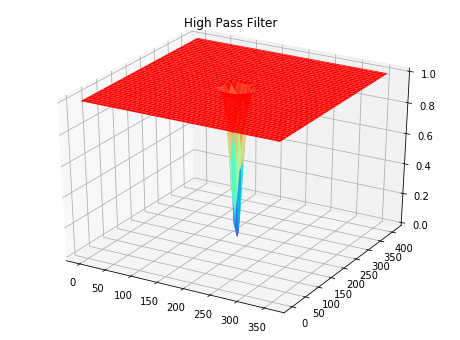

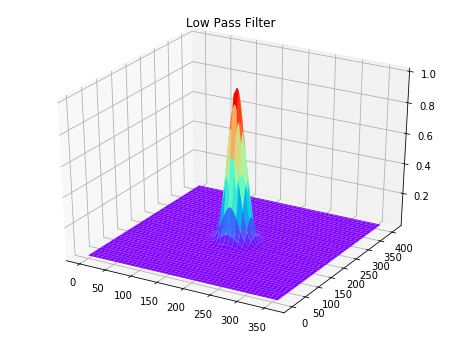

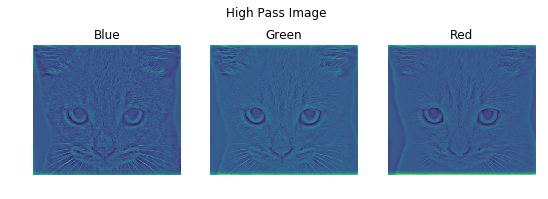

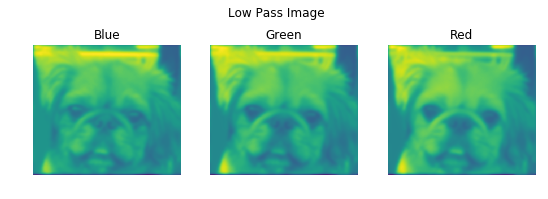

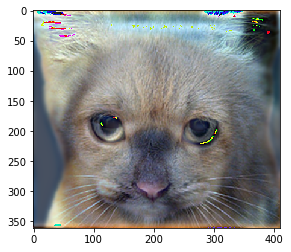

In [3]:
high_bgr = []
highFreqImg = cv2.imread('hw2_data/task1and2_hybrid_pyramid/cat.bmp')
for img in cv2.split(highFreqImg):
    img = img.astype(np.float64)
    high_bgr.append(img)

low_bgr = []
lowFreqImg = cv2.imread('hw2_data/task1and2_hybrid_pyramid/dog.bmp')
for img in cv2.split(lowFreqImg):
    img = img.astype(np.float64)
    low_bgr.append(img)

hybridImg = hybrid_image(high_bgr, low_bgr, 10, 15)
hybridImg = hybridImg.astype(np.uint8)

plt.imshow(cv2.merge([hybridImg[2], hybridImg[1], hybridImg[0]]))
plt.show()